## Business Understanding

The **Iowa Alcoholic Beverages Division** is the alcoholic beverage control authority for the U.S. state of Iowa. Since March 8, 1934, it has regulated the traffic in, and maintained a monopoly on the wholesaling of, alcoholic beverages in the state, thus making Iowa an *alcoholic beverage control state*.
<br><br>
**Alcoholic beverage control states**, generally called control states, are 17 states in the United States that, as of 2016, have state monopoly over the wholesaling or retailing of some or all categories of alcoholic beverages, such as beer, wine, and distilled spirits.

## Data Understanding

### Iowa Liquor Retail Sales Dataset

This dataset contains every wholesale purchase of liquor in the State of Iowa by retailers for sale to individuals since January 1, 2012. The State of Iowa controls the wholesale distribution of liquor intended for retail sale, which means this dataset offers a complete view of retail liquor sales in the entire state. The dataset contains every wholesale order of liquor by all grocery stores, liquor stores, convenience stores, etc., with details about the store and location, the exact liquor brand and size, and the number of bottles ordered.
<br><br>
In addition to being an excellent dataset for analyzing liquor sales, this is a large and clean public dataset of retail sales data.
<br><br>
Because of the limitation from the free account, BiqQuery only allows 16000 rows to be downloaded from each query. So I will collect **sample** of the Iowa Liquor Retail Sales dataset using **stratified sampling**. I will collect sample from each year starting from 2012 up to 2020.I will collect 16000 rows of data using **simple random sampling**. That way, I will have an evenly distributed dataset. This sample result will extrapolate to the population, which is the whole data in the Iowa Liquor Retail Sales dataset.
<br><br>
Below is the SQL Query to collect the samples.

In [1]:
# BigQuery SQL Query
'''
#standardSQL
SELECT *, EXTRACT(ISOYEAR FROM iowa_liquor.date) as Year, 
FROM `bigquery-public-data.iowa_liquor_sales.sales` AS iowa_liquor
WHERE EXTRACT(ISOYEAR FROM iowa_liquor.date) = 2020 
    AND (iowa_liquor.store_location IS NULL) = FALSE
    AND (iowa_liquor.category IS NULL) = FALSE 
LIMIT 16000
'''

'\n#standardSQL\nSELECT *, EXTRACT(ISOYEAR FROM iowa_liquor.date) as Year, \nFROM `bigquery-public-data.iowa_liquor_sales.sales` AS iowa_liquor\nWHERE EXTRACT(ISOYEAR FROM iowa_liquor.date) = 2020 \n    AND (iowa_liquor.store_location IS NULL) = FALSE\n    AND (iowa_liquor.category IS NULL) = FALSE \nLIMIT 16000\n'

I have downloaded all the required datasets. Now I'm going to load these datasets and merge it into one whole dataset called 'iowa_df'.

In [2]:
# Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from geopy.geocoders import Nominatim
import folium
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import datapane as dp

In [3]:
# Datapane Login Token
dp.login(token="Insert login token here")

Connected successfully to https://datapane.com as jonando93


In [4]:
# Change Working Directory
os.chdir(r"C:\Users\Asus\Desktop\Jonando\machine-learning\Supporting Files")

In [5]:
# Load Dataset - Iowa 2012
iowa_2012 = pd.read_csv('SRS_iowa_liquor_2012.csv')
iowa_2013 = pd.read_csv('SRS_iowa_liquor_2013.csv')
iowa_2014 = pd.read_csv('SRS_iowa_liquor_2014.csv')
iowa_2015 = pd.read_csv('SRS_iowa_liquor_2015.csv')
iowa_2016 = pd.read_csv('SRS_iowa_liquor_2016.csv')
iowa_2017 = pd.read_csv('SRS_iowa_liquor_2017.csv')
iowa_2018 = pd.read_csv('SRS_iowa_liquor_2018.csv')
iowa_2019 = pd.read_csv('SRS_iowa_liquor_2019.csv')
iowa_2020 = pd.read_csv('SRS_iowa_liquor_2020.csv')

In [6]:
# Create iowa_list variable
iowa_list = [iowa_2012, iowa_2013, iowa_2014, iowa_2015, iowa_2016, iowa_2017, iowa_2018, iowa_2019, iowa_2020]

# Create 'Month' and 'Quarter' columns for each dataset
for iowa in iowa_list:
    iowa['Month'] = pd.DatetimeIndex(iowa['date']).month
    iowa['Quarter'] = pd.DatetimeIndex(iowa['date']).quarter

In [7]:
iowa_df = pd.concat(iowa_list)
iowa_df.shape

(144000, 27)

In [8]:
# Check for missing value
iowa_df.isna().sum()

invoice_and_item_number      0
date                         0
store_number                 0
store_name                   0
address                      0
city                         0
zip_code                     1
store_location               0
county_number              613
county                     613
category                     0
category_name                0
vendor_number                0
vendor_name                  0
item_number                  0
item_description             0
pack                         0
bottle_volume_ml             0
state_bottle_cost            0
state_bottle_retail          0
bottles_sold                 0
sale_dollars                 0
volume_sold_liters           0
volume_sold_gallons          0
Year                         0
Month                        0
Quarter                      0
dtype: int64

As shown above, there are missing values in multiple columns (*county_number*, *county*, *zip_code*), but these missing values are distinguishable. For these columns, we can simply use *store_location* coordinate to know the county origin and its zip code. This method is called Reverse Geolocation, using Nominatim API.

In [9]:
# iowa_df Data Types
iowa_df.dtypes

invoice_and_item_number     object
date                        object
store_number                 int64
store_name                  object
address                     object
city                        object
zip_code                    object
store_location              object
county_number              float64
county                      object
category                     int64
category_name               object
vendor_number                int64
vendor_name                 object
item_number                  int64
item_description            object
pack                         int64
bottle_volume_ml             int64
state_bottle_cost          float64
state_bottle_retail        float64
bottles_sold                 int64
sale_dollars               float64
volume_sold_liters         float64
volume_sold_gallons        float64
Year                         int64
Month                        int64
Quarter                      int64
dtype: object

After reviewing the dataset, I noticed that the 'store_location' column has values in this format **POINT (93.000 43.000)**. In order for us to properly explore the data, I have to create 2 new columns, which is 'store_latitude' and 'store_longitude'. These coordinates will be useful later to find informations about store locations in Iowa.

In [10]:
# Reformat 'store_location' column
iowa_df['store_location'] = iowa_df['store_location'].str[7:-1]

# Split between latitude and longitude
store_loc = iowa_df['store_location'].str.split(" ", n=1, expand=True)

# Create 'store_lat' column
iowa_df['store_lng'] = store_loc[0]

# Create 'store_lng' column
iowa_df['store_lat'] = store_loc[1]

In [11]:
# Save iowa_df to csv file
iowa_df.to_csv('iowa_df.csv', index=False)

## Exploratory Data Analysis

In this section, I am going to explore the dataset to collect as much insights as possible that can be used to improve the performance in the following year. For example, to collect information regarding which brand is the most popular, so we can strategize or plan based on that insight for the following year.
<br><br>
In Exploratory Data Analysis phase, before we deep dive into the data, it is always a good start to view basic statistical details for both **Categorical Value** columns and **Continuous Value** columns. *It is a bad idea to deep diving while under the influence of alcohol. It is kinda ironic that now we have to deep dive into the Liquor Retail Sales data. xD*

In [12]:
categorical = ['invoice_and_item_number', 'city', 'store_number', 'county_number', 'category', 'vendor_number', 'pack', 'bottle_volume_ml', 'Year', 'Month', 'Quarter']

# View basic statistical detail - Categorical values
iowa_df[categorical].astype('object').describe()

,invoice_and_item_number,city,store_number,county_number,category,vendor_number,pack,bottle_volume_ml,Year,Month,Quarter
count,144000,144000,144000,143387.0,144000,144000,144000,144000,144000,144000,144000
unique,144000,799,2160,99.0,79,156,15,33,9,12,4
top,S18826800020,Des Moines,2633,77.0,1062200,434,12,750,2012,12,4
freq,1,6515,2209,25510.0,17616,30449,91940,85904,16000,15104,39651


In [13]:
continuous = ['state_bottle_cost', 'state_bottle_retail', 'bottles_sold', 'sale_dollars', 'volume_sold_liters', 'volume_sold_gallons']

# View basic statistical detail - Continuous values
iowa_df[continuous].describe()

,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons
count,144000.000000,144000.000000,144000.000000,144000.000000,144000.000000,144000.000000
mean,11.479538,17.229691,10.206132,147.022683,9.599032,2.534972
std,11.579644,17.367262,30.178681,494.103414,35.986364,9.506516
min,0.000000,0.000000,1.000000,0.000000,0.050000,0.010000
25%,5.480000,8.220000,2.000000,33.750000,1.500000,0.400000
50%,8.260000,12.390000,6.000000,73.110000,4.500000,1.190000
75%,14.690000,22.040000,12.000000,148.680000,10.500000,2.770000
max,1599.200000,2398.800000,2304.000000,45343.200000,3528.000000,931.990000


### Iowa Liquor Retail Sales per Year

In [14]:
# Groupby 'Year' column using sum() of 'sale_dollars' column
iowa_df_yearly_sales = iowa_df.groupby('Year')['sale_dollars'].sum()

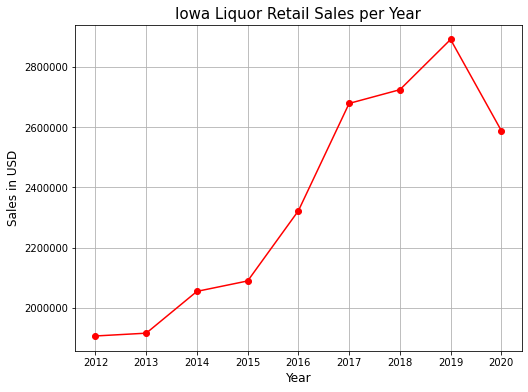

In [15]:
# Visualize the data
fig = plt.figure(figsize=(8, 6))
plot_1 = iowa_df_yearly_sales.plot(kind='line', 
                               color='red', 
                               marker='o', 
                               grid=True)
plot_1 = plt.title('Iowa Liquor Retail Sales per Year', fontsize=15)
plot_1 = plt.xlabel('Year', fontsize=12)
plot_1 = plt.ylabel('Sales in USD', fontsize=12)
plot_1 = plt.ticklabel_format(style='plain')
plot_1

In [17]:
# Save yearly sales plot to html file
dp.Report(dp.Plot(fig)).save(path='Iowa Liquor Yearly Sales.html', open=True)

Thanks for using **Datapane**, to automate and securely share reports in your organization please visit [Datapane Enterprise](https://datapane.com/enterprise/)

In [18]:
# Publish plot to datapane
dp.Report(dp.Plot(fig)).publish(name='Iowa Liquor Yearly Sales')

Publishing report and associated data - please wait..
Report successfully published at https://datapane.com/u/jonando93/reports/iowa-liquor-yearly-sales/


Based on this line chart, it looks like the amount of liquor sold is increasing every year with the highest incline between 2016 to 2017. However, it starts to decline a little during 2019 to 2020. As seen on this graph, the amount of liquor sold in 2020 is lower than previous years, it is due to the fact that there was a global pandemic around 2020 and still is up to this day.

### Iowa Liquor Retail Monthly Sales per Year

In [19]:
# Groupby 'Year' and 'Month' columns using sum() of 'sale_dollars' column
iowa_df_monthly_sales = iowa_df.groupby(['Year','Month'])['sale_dollars'].sum()

Text(-32.5, 525000, 'Sales in USD')

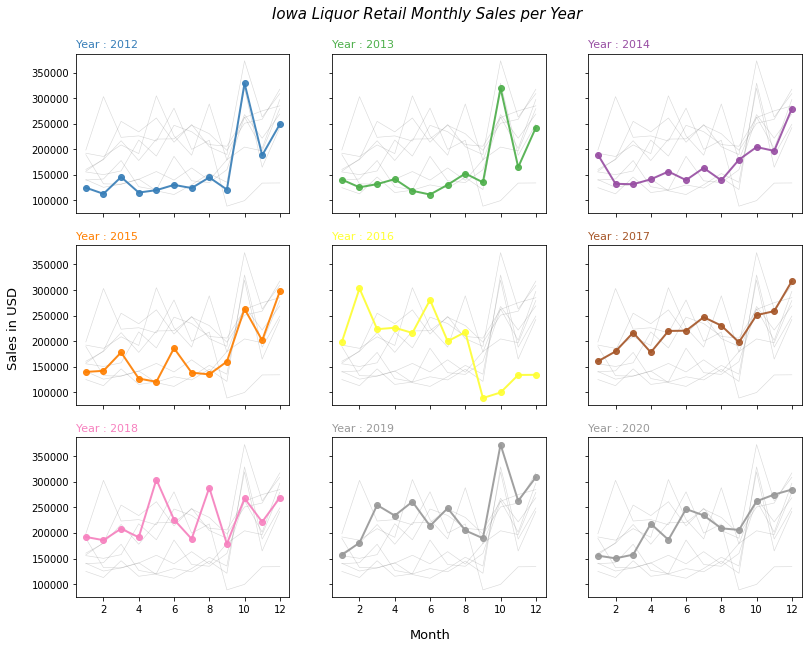

In [20]:
# Adjust plot size
fig = plt.figure(figsize=(13, 10))

# create a color palette
palette = plt.get_cmap('Set1')

# Multi-line plot
xs_index = [2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]
num = 0
for xs in xs_index:
    num += 1
    
    #create a sub-plot (use num to set position of each plot)
    plt.subplot(3,3,num)    
    
    # plot every group, but using slightly deemed color
    for x in xs_index:
        iowa_df_monthly_sales.xs(x).plot(color='grey', linewidth=0.6, alpha=0.3)
    
    iowa_df_monthly_sales.xs(xs).plot(marker='o', color=palette(num), linewidth=2, alpha=0.9, label=xs)
    
    #Remove xlabel
    plt.xlabel("")
    
    # Set y limit for every plot
    plt.xlim()
    plt.ylim()
    
    # Remove unnecessary x and y ticks
    if num in range(7):
        plt.tick_params(axis='x',labelbottom=False)
    if num not in [1,4,7]:
        plt.tick_params(labelleft=False)
        
    # Add title for each plot
    plt.title('Year : {}'.format(xs), loc='left', fontsize=11, fontweight=0, color=palette(num))

# Add general title
plt.suptitle("Iowa Liquor Retail Monthly Sales per Year", fontsize=15, fontweight=0, color='black', style='italic', y=0.945)

# Axis title
plt.text(-8.5, 0.02, 'Month', ha='center', va='center', fontsize=13)
plt.text(-32.5, 525000, 'Sales in USD', rotation='vertical', fontsize=13) 

In [21]:
# Save yearly sales plot to html file
dp.Report(dp.Plot(fig)).save(path='Iowa Liquor Monthly Sales.html', open=True)

In [22]:
# Publish plot to datapane
dp.Report(dp.Plot(fig)).publish(name='Iowa Liquor Monthly Sales 2012-2020')

Publishing report and associated data - please wait..
Report successfully published at https://datapane.com/u/jonando93/reports/iowa-liquor-monthly-sales-2012-2020/


Based on this multi-line chart, we found out that in October and December every year liquor sales are above 250000 USD, only exception in October 2014, October 2016 and December 2016 where liquor sales are below 250000 USD.
<br><br>
The reason behind the huge amount of liquor sales occurred in October and December is because there are multiple holidays and festivals in US during these months. One of the most popular in October is Halloween, but there are also National Hispanic Heritage Month, Columbus Day and Indigenous People Day Celebration. In December, there are Christmas Day and also New Year Celebration.

### Top 5 Types of Liquor Sold per Year

Due to some of the category name in 'category_name' column has long character string, it is hard to visualize all the subplots if we have to use 'category_name' as labels. So I have to divide these 9 plots into a group of 3 plots, which is 2012 - 2014, 2015 - 2017, 2018 - 2020.
<br><br>
Because I have to repeat this process multiple times, I define a function to visualize all the subplots in one group, where a group consists of 3 plots. But before I define a function, I have to collect the data regarding top 5 liquor sold each year.

In [23]:
top_5_liquor_per_year = iowa_df.groupby(['Year','category_name']).agg({'sale_dollars':sum})
top_5_liquor_per_year = top_5_liquor_per_year['sale_dollars'].groupby('Year', group_keys=False).nlargest(5)

In [39]:
# Define a function to visualize all the subplots in a group
def TopFivePerYear(data, year_1, year_2, num=0):
    # Adjust plot size
    fig = plt.figure(figsize=(7, 10))

    # create a color palette
    palette = plt.get_cmap('Set1')

    # Multi-line plot
    year_to_year = list(range(year_1, year_2 + 1))
    num = 0
    for year in year_to_year:        
        num += 1
        
        #create a sub-plot (use num to set position of each plot)
        plt.subplot(3,1,num)    
    
        data.xs(year).plot(kind='barh', color=palette(num), linewidth=2, alpha=0.9, label=year)
    
        # Change the y ticklabel format from scientific to plain
        plt.ticklabel_format(axis='x', style='plain')
    
        plt.xticks(rotation=0)
    
        # Remove x and y label
        plt.ylabel("")
        plt.xlabel("Sales in USD", fontsize=11)
    
        # Set y limit for every plot
        plt.xlim(0, 1200000)
    
        # Remove unnecessary x and y ticks
        if num in [1, 2]:
            plt.tick_params(labelbottom=False)
            plt.xlabel("")
        
        # Add title for each plot
        plt.title('Year : {}'.format(year), loc='center', fontsize=11, fontweight=0, color=palette(num))

    # Add general title
    plt.suptitle("Top 5 Types of Liquor Sold ({} - {})".format(year_1, year_2), fontsize=15, fontweight=0, color='black', style='italic', y=0.945)


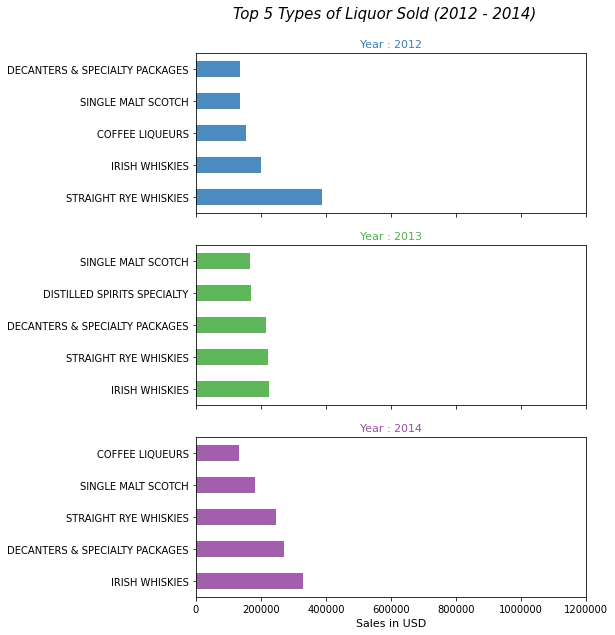

In [25]:
# Top 5 Types of Liquor Sold in 2012 to 2014
TopFivePerYear(top_5_liquor_per_year,2012,2014)

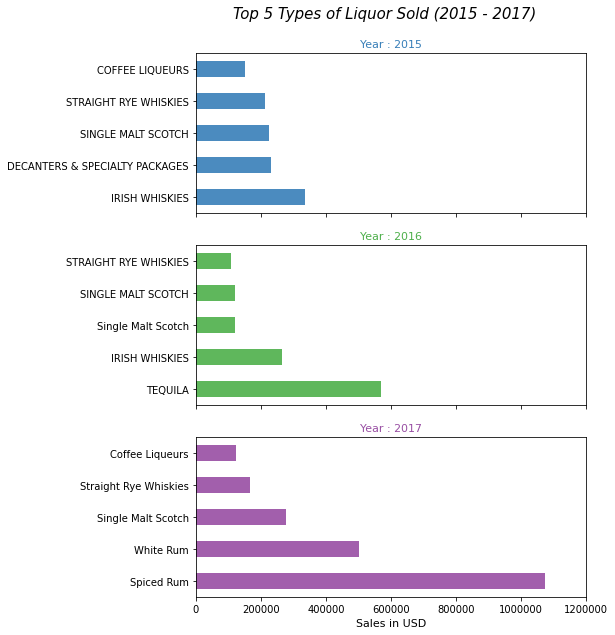

In [26]:
# Top 5 Types of Liquor Sold in 2015 to 2017
TopFivePerYear(top_5_liquor_per_year,2015,2017)

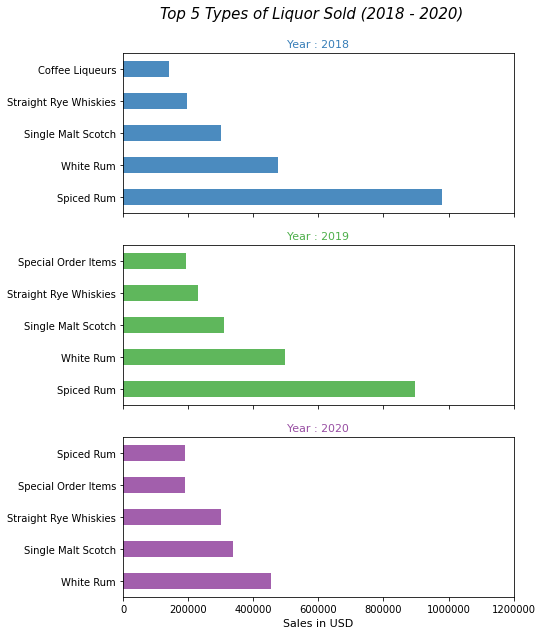

In [40]:
# Top 5 Types of Liquor Sold in 2018 to 2020
TopFivePerYear(top_5_liquor_per_year,2018,2020)

For 4 years straight, from 2012 to 2015, whiskies are the most popular in Iowa and followed by Tequila in 2016. Then from 2017 onwards, both White Rum and Spiced Rum dominates the market in Iowa with the highest sales went above 1 million USD in 2017. From these graphs, we can see that the demand in the market were shifting from Whisky to Rum.

### Top 3 Brands From Most Favorite Type of Liquor per Year

In [41]:
top_3_brand_per_year = iowa_df.groupby(['Year','category_name','item_description']).agg({'sale_dollars':'sum'})
top_3_brand_per_year = top_3_brand_per_year['sale_dollars'].groupby(['Year','category_name'], group_keys=False).nlargest(3)

In [42]:
# Define a function to visualize all the subplots in a group
def TopBrandPerYear(data, year_1, year_2, num=0):
    # Adjust plot size
    fig = plt.figure(figsize=(7, 10))

    # create a color palette
    palette = plt.get_cmap('Set1')

    # Multi-line plot
    year_to_year = list(range(year_1, year_2 + 1))
    fav_liquor_per_year = {2012:'STRAIGHT RYE WHISKIES', 
                           2013:'IRISH WHISKIES', 
                           2014:'IRISH WHISKIES', 
                           2015:'IRISH WHISKIES', 
                           2016:'TEQUILA', 
                           2017:'Spiced Rum',
                           2018:'Spiced Rum',
                           2019:'Spiced Rum', 
                           2020:'White Rum'}
    num = 0
    for year in year_to_year:
        num += 1
    
        #create a sub-plot (use num to set position of each plot)
        plt.subplot(3,1,num)    
    
        data.xs((year, fav_liquor_per_year.get(year))).plot(kind='barh', 
                                                            color=palette(num), 
                                                            linewidth=2, 
                                                            alpha=0.9, 
                                                            label=year)
    
        # Change the x ticklabel format from scientific to plain
        plt.ticklabel_format(axis='x', style='plain')
    
        plt.xticks(rotation=0)
    
        # Remove y label and rename x label
        plt.ylabel("")
        plt.xlabel("Sales in USD", fontsize=11)
    
        # Set y limit for every plot
        plt.xlim(0, 500000)
    
        # Remove unnecessary x and y ticks
        if num in [1, 2]:
            plt.tick_params(labelbottom=False)
            plt.xlabel("")
        
        # Add title for each plot
        plt.title('Year : {} ({})'.format(year, fav_liquor_per_year.get(year)), 
                  loc='center', 
                  fontsize=11, 
                  fontweight=0, 
                  color=palette(num))

    # Add general title
    plt.suptitle("Top 3 Brands From Most Favourite Type of Liquor Sold ({} - {})".format(year_1, year_2), 
                 fontsize=15, 
                 fontweight=0, 
                 color='black', 
                 style='italic', 
                 y=0.945)


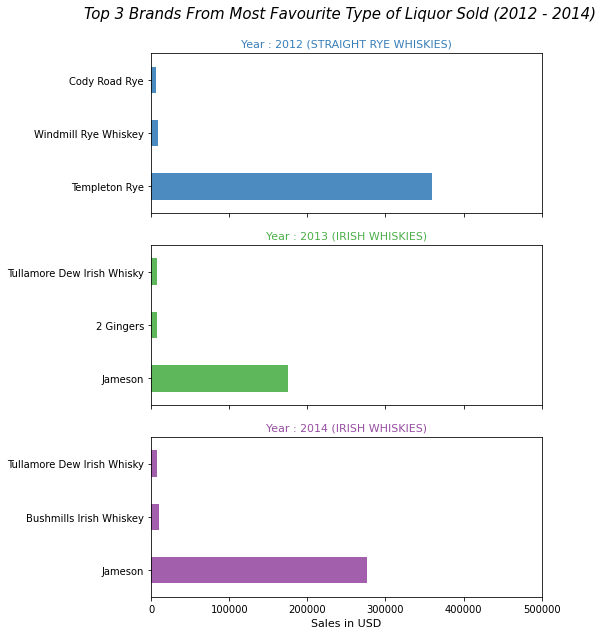

In [43]:
# Top 3 Brands 2012 - 2014
TopBrandPerYear(top_3_brand_per_year,2012,2014)

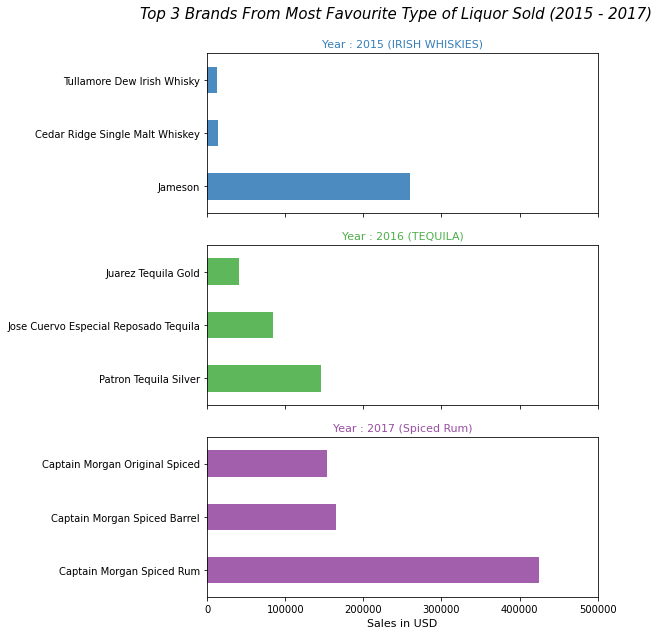

In [44]:
# Top 3 Brands 2015 - 2017
TopBrandPerYear(top_3_brand_per_year,2015,2017)

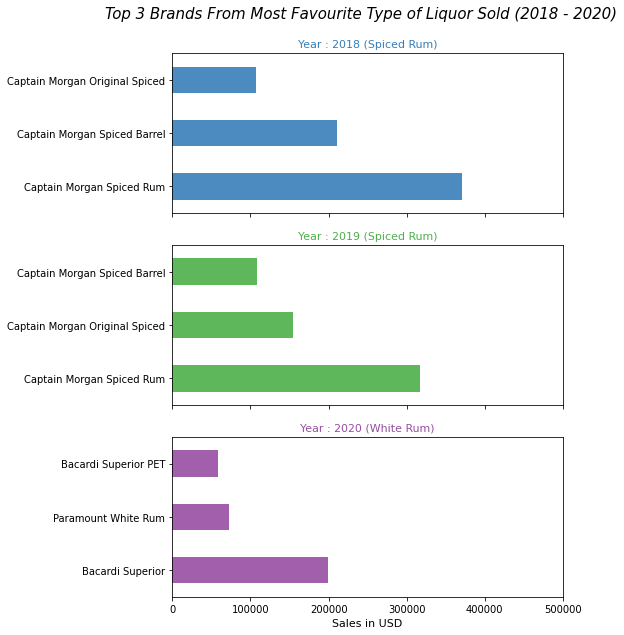

In [45]:
# Top 3 Brands 2018 - 2020
TopBrandPerYear(top_3_brand_per_year,2018,2020)

In summary from these Top 3 Brands graphs, it is certain that from each type of liquor, no matter what year it is, the brand is always the same. For example, the top brand for Irish Whiskey every year is always Jameson (*Jameson is a good whiskey!*), Spiced Rum is always Captain Morgan, and for White Rum it appears that Bacardi is..Superior. (*Pun intended.*)

### Top 100 Big Spenders in Iowa in 2020

The Capital city for Iowa state is Des Moines, and it is also a metropolitan city. Based on this information alone, I have no doubt that the huge amount of sales occurred in this county, but I am still curious whether that statement is true or not. So, I will use 100 rows of data from 'store_location' column to pinpoint the location of each store that has most amount of transaction value.

In this analysis, I require an API called Nominatim. Nominatim is an API that uses data to find locations on Earth by name and address. It can also do the reverse, find an address for any location on the planet. This method is called **Geocoding**.

In [46]:
# Create new dataframe that only contains necessary columns
top_100_spenders_2020 = iowa_df.loc[iowa_df['Year'] == 2020]
top_100_spenders_2020 = top_100_spenders_2020.nlargest(100, 'sale_dollars')

In [47]:
# Collect Iowa's coordinate
coord_iowa = 'Iowa, United States of America'
geolocator_iowa = Nominatim(user_agent='chris_p_bacon_xD')
location_iowa = geolocator_iowa.geocode(coord_iowa)
latitude_iowa = location_iowa.latitude
longitude_iowa = location_iowa.longitude
print('The geographical coordinate of Iowa are {}, {}'.format(latitude_iowa, longitude_iowa))

# Create a Map of Iowa
map_iowa = folium.Map(location=[latitude_iowa, longitude_iowa], zoom_start=7.5)

# Add markers to the map
for lat, lng, city, county in zip(top_100_spenders_2020['store_lat'], 
                          top_100_spenders_2020['store_lng'], 
                          top_100_spenders_2020['city'], 
                          top_100_spenders_2020['county']):
    label = 'City: {} | County: {}'.format(city, county)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker([lat, lng],
                       radius=5,
                       popup=label,
                       color='blue',
                       fill=True,
                       fill_color='#FFD700',
                       fill_opacity=0.7,
                       parse_html=False).add_to(map_iowa)

map_iowa

The geographical coordinate of Iowa are 41.9216734, -93.3122705


In [48]:
# Save yearly sales plot to html file
dp.Report(dp.Plot(map_iowa)).save(path='Map of Iowa.html', open=True)

In [49]:
# Publish plot to datapane
dp.Report(dp.Plot(map_iowa)).publish(name='Map of Iowa')

Publishing report and associated data - please wait..
Report successfully published at https://datapane.com/u/jonando93/reports/map-of-iowa/


As we can see based on the Folium map, Des Moines has the most frequent purchase in top 100 sales data, so that also means the statement is true. The other cities that has alot of sales is in Sioux City, Iowa City, Omaha, and Davenport

### Correlation (Heatmap)

Before I proceed to create a heatmap to find correlation between each column (variable), I have to create new dataframe that remove any unnecessary columns, and I want to adjust the columns in this new dataframe so that it would be compatible for building a ML model.

In [50]:
# Drop unnecessary columns from iowa_df dataframe to create new dataframe for ML model
iowa_sales_df = iowa_df.drop(['invoice_and_item_number',
                              'date',
                              'store_number',
                              'store_name',
                              'address',
                              'zip_code',
                              'store_location',
                              'county_number',
                              'county',
                              'category',
                              'category_name',
                              'vendor_number',
                              'vendor_name',
                              'item_number',
                              'item_description',
                              'pack','Quarter',
                              'store_lng',
                              'store_lat'], axis=1)
iowa_sales_df.head()

,city,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,Year,Month
0,CEDAR RAPIDS,1000,2.13,3.19,96,306.24,96.0,25.36,2012,6
1,DENISON,1000,4.51,6.76,120,811.20,120.0,31.70,2012,3
2,LE MARS,1000,4.75,7.13,4,28.52,4.0,1.06,2012,11
3,DES MOINES,50,6.99,10.49,6,62.94,0.3,0.08,2012,8
4,PELLA,750,14.50,21.75,36,783.00,27.0,7.13,2012,10


Based on the independent variables that I selected (except 'city', 'Year', 'Month' columns, and also since 'sale_dollars' column is a target variable), bottle_volume_ml column is a categorical value. In order to create a ML model, in this case **Linear Regression**, I have to breakdown these categorical values into new columns. Let's see how the categorical values are distributed in *'bottle_volume_ml'* column.

In [51]:
iowa_sales_df['bottle_volume_ml'].value_counts()[0:10]

750     85904
1000    25273
1750    17677
375      7496
500      3156
50       1652
200      1298
600       827
300       120
100       104
Name: bottle_volume_ml, dtype: int64

It appears that 750ml, 1000ml, and 1750ml are most common type. Then I will create 4 new columns for each type of bottle volume (the 4th column would be the rest of bottle volume type).

In [52]:
# Create new column for 750ml
iowa_sales_df['vol_750ml_sale_dollars'] = np.where(iowa_sales_df['bottle_volume_ml'] == 750, 
                                                   iowa_sales_df['sale_dollars'], 0)

# Create new column for 1000ml
iowa_sales_df['vol_1000ml_sale_dollars'] = np.where(iowa_sales_df['bottle_volume_ml'] == 1000, 
                                                    iowa_sales_df['sale_dollars'], 0)

# Create new column for 1750ml
iowa_sales_df['vol_1750ml_sale_dollars'] = np.where(iowa_sales_df['bottle_volume_ml'] == 1750, 
                                                    iowa_sales_df['sale_dollars'], 0)

# Create new column for other bottle types
conditions = (iowa_sales_df['bottle_volume_ml'] != 750) | (iowa_sales_df['bottle_volume_ml'] != 1000) | (iowa_sales_df['bottle_volume_ml'] != 1750)
value = iowa_sales_df['sale_dollars'] - (iowa_sales_df['vol_750ml_sale_dollars'] + iowa_sales_df['vol_1000ml_sale_dollars'] + iowa_sales_df['vol_1750ml_sale_dollars'])
iowa_sales_df['other_vol_sale_dollars'] = np.where(conditions, value, 0)

In [53]:
# Remove 'bottle_volume_ml' column
iowa_sales_df.drop(['bottle_volume_ml'], axis=1, inplace=True)

In [54]:
# Readjust dataframe
iowa_sales_df = iowa_sales_df.groupby(['Year','Month']).sum()
iowa_sales_df.reset_index(inplace=True)

In [ ]:
# Save 'iowa_sales_df' dataframe to csv
iowa_sales_df.to_csv('iowa_sales_df.csv', index=False)

Linear regression is a statistical approach for modelling relationship between a dependent variable (sale_dollars) with a given set of independent variables. This dataset contains liquor sales record from 2012 to 2020. I'm going to use Linear Regression method to predict sales in 2020.

In [55]:
# Create corr variable to save correlation of each column results
corr = iowa_sales_df[iowa_sales_df.columns[2:]].corr(method='pearson')

[Text(0.5, 0, 'state_bottle_cost'),
 Text(1.5, 0, 'state_bottle_retail'),
 Text(2.5, 0, 'bottles_sold'),
 Text(3.5, 0, 'sale_dollars'),
 Text(4.5, 0, 'volume_sold_liters'),
 Text(5.5, 0, 'volume_sold_gallons'),
 Text(6.5, 0, 'vol_750ml_sale_dollars'),
 Text(7.5, 0, 'vol_1000ml_sale_dollars'),
 Text(8.5, 0, 'vol_1750ml_sale_dollars'),
 Text(9.5, 0, 'other_vol_sale_dollars')]

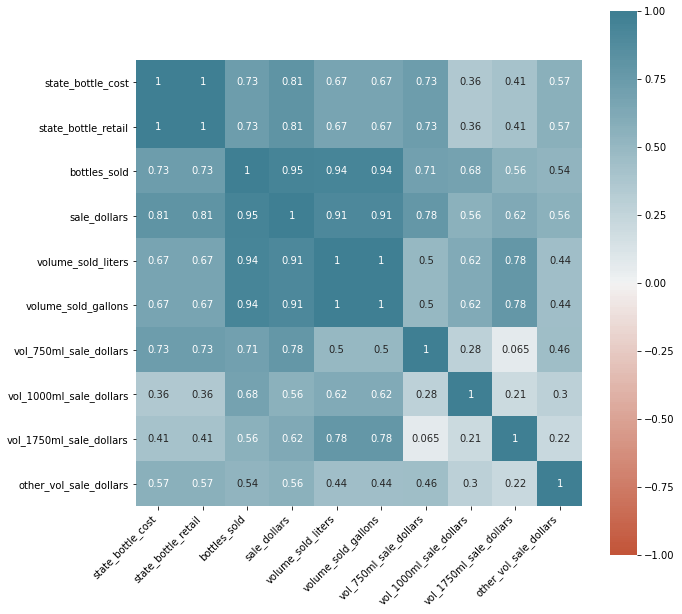

In [56]:
# Create Heatmap
fig = plt.figure(figsize=(10,10))
ax = sns.heatmap(
    corr,
    annot=True,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

In [60]:
# Save yearly sales plot to html file
dp.Report(dp.Plot(fig)).save(path='Heatmap - Iowa Dataset', open=True)

In [61]:
# Publish plot to datapane
dp.Report(dp.Plot(fig)).publish(name='Heatmap - Iowa Dataset')

Publishing report and associated data - please wait..
Report successfully published at https://datapane.com/u/jonando93/reports/heatmap-iowa-dataset/


Based on the correlation value generated by the heatmap, we can see that in sale_dollars columns, the lowest value is 0.54 which is the correlation between 'sale_dollars' and 'other_vol_sale_dollars'. I am going to use this dataset to build a Machine Learning - Linear Regression Model to predict the sales in 2020. 

## Machine Learning - Linear Regression

To build ML model, the dataset should be split into two parts which is train & test set. Train set will be used for training the Machine Learning model, while test set will be used to calculate the accuracy of the previously trained model. Our goal is to predict sales, so that means our **target/dependent variable** is 'sale_dollars' column, while the other columns are our **independent variables**.

In [62]:
# Create train and test dataset
train_df = iowa_sales_df[iowa_sales_df.columns[2:]].loc[iowa_sales_df['Year'] != 2020]
test_df = iowa_sales_df[iowa_sales_df.columns[2:]].loc[iowa_sales_df['Year'] == 2020]
print(train_df.shape, test_df.shape)

# Create new variables called X_train, y_train, X_test, y_test
X_train = train_df.drop(['sale_dollars', 'bottles_sold', 'volume_sold_liters', 'volume_sold_gallons', 'other_vol_sale_dollars'], axis=1)
y_train = train_df['sale_dollars']
X_test = test_df.drop(['sale_dollars', 'bottles_sold', 'volume_sold_liters', 'volume_sold_gallons', 'other_vol_sale_dollars'], axis=1)
y_test = test_df['sale_dollars']

(96, 10) (12, 10)


Variance Score: 0.9889765193431822


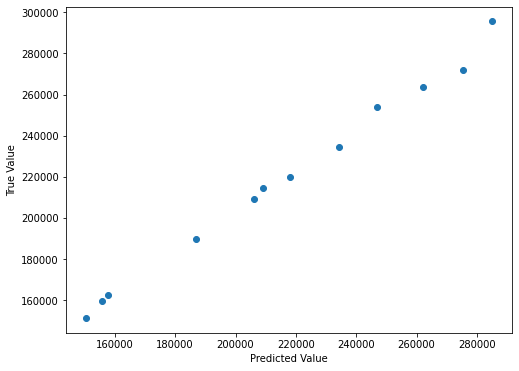

In [65]:
# Instantiate linear model for ease of coding below
lm = linear_model.LinearRegression()

# Fit our X_train and y_train variables to train the model
model = lm.fit(X_train, y_train)

# Use X_test and y_test variables to predict new data using the model
predict = lm.predict(X_test)

# Using scatter plot to see the result
fig = plt.figure(figsize=(8,6))
plt.scatter(y_test, predict)
plt.xlabel('Predicted Value')
plt.ylabel('True Value')

# Check variance score, 
print('Variance Score: {}'.format(model.score(X_test, y_test)))

In [66]:
# Create new dataframe 'iowa_sales_2020'
iowa_sales_2020 = iowa_sales_df.loc[iowa_sales_df['Year'] == 2020]

# Insert the prediction result to Iowa sales in 2020 dataframe
iowa_sales_2020['sale_dollars_pred'] = predict

c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Let's compare our result with the Iowa Retail Liquor Sales per Year graph.

In [67]:
# Create new variable that saves predicted sales in 2020 value
grouped_iowa_sales_2020 = iowa_sales_2020.groupby('Year')['sale_dollars_pred'].sum()

# Create new variable to replace sales in 2020 to predicted sales in 2020
pred_iowa_df_yearly_sales = iowa_df_yearly_sales.replace(iowa_df_yearly_sales[2020], grouped_iowa_sales_2020.sum())

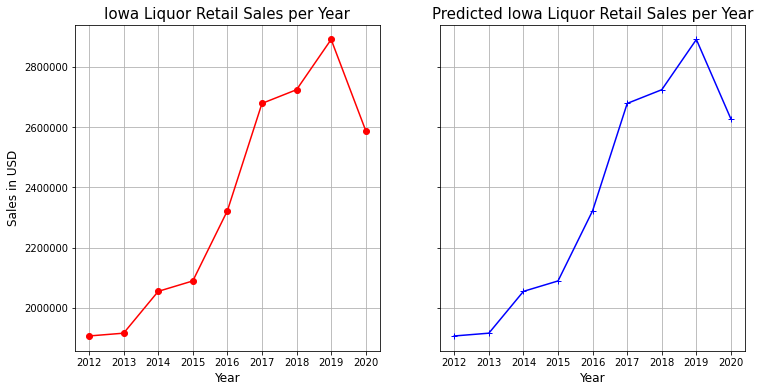

In [68]:
# Visualize the data
fig = plt.figure(figsize=(12, 6))

# subplot 1 - Liquor Sales per Year
plt.subplot(1,2,1)  
iowa_df_yearly_sales.plot(kind='line', 
                          color='red', 
                          marker='o', 
                          grid=True)
plt.title('Iowa Liquor Retail Sales per Year', fontsize=15)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Sales in USD', fontsize=12)
plt.ticklabel_format(style='plain')

# subplot 2 - Predicted Liquor Sales per Year
plt.subplot(1,2,2)
pred_iowa_df_yearly_sales.plot(kind='line', 
                          color='blue', 
                          marker='+', 
                          grid=True)
plt.title('Predicted Iowa Liquor Retail Sales per Year', fontsize=15)
plt.tick_params(labelleft=False)
plt.xlabel('Year', fontsize=12)
plt.ticklabel_format(style='plain')



In [69]:
# Save yearly sales plot to html file
dp.Report(dp.Plot(fig)).save(path='Iowa Liquor Yearly Sales vs Predicted', open=True)

In [70]:
# Publish plot to datapane
dp.Report(dp.Plot(fig)).publish(name='Iowa Liquor Yearly Sales vs Predicted')

Publishing report and associated data - please wait..
Report successfully published at https://datapane.com/u/jonando93/reports/iowa-liquor-yearly-sales-vs-predicted/


## Conclusion

The Linear Regression model predicts that in 2020 the liquor sales amount is *USD 2,626,510.06*, which is slightly higher than the real value (*USD 2,588,159.34*).

Linear Regression model that we've build has a variance score of 98%. In other words, this machine learning model is able to predict the 'sale_dollars' based on variables from bottle volume sales of 750ml, 1000ml, and 1750ml. Based on this result, I am pretty sure that this model also able to predict the sales amount in 2021 by only using 750ml, 1000ml, and 1750ml bottle volume sales.
<br><br>
The reason why this model has such a high score is because the dataset is clean, meaning there are no noise (randomness) or even outlier contained in the dataset. Noise and outlier can affect the score and accuracy of the model. Also, the accuracy will be lower when it is applied to population. This data is only a sample that represents the whole records of Iowa Retail Liquor Sales data.
<br><br>
It is more reliable to predict sales based on bottle volumes rather than types of liquor (e.g. Vodka, Whiskey, Rum, etc.). Because, based on our findings in **section 3.3 Top 5 Types of Liquor Sold per Year**, it is clear that most common types of liquor sold is changing every year.